In [1]:
import matplotlib.pyplot as plt
import mlxtend.frequent_patterns
import mlxtend.preprocessing
import numpy
import pandas

In [7]:
online = pandas.read_csv(
    "OnlineRetail.csv",
    encoding="ISO-8859-1"  # rất quan trọng với dữ liệu Online Retail
)
# create new column called IsCPresent
online['IsCPresent'] = ( # looking for C in InvoiceNo column
    online['InvoiceNo'] # convert column to string type for the apply function below

    .astype(str) # set element to 1 if C present otherwise 0
    .apply(lambda x: 1 if x.find('C') != -1 else 0)
)
online1 = (
    online # filter out non-positive quantity values
    .loc[online["Quantity"] > 0] # remove InvoiceNos starting with C
    .loc[online['IsCPresent'] != 1] # column filtering
    .loc[:, ["InvoiceNo", "Description"]]# dropping all rows with at least one missing value

    .dropna()
)
# extract unique invoice numbers as list
invoice_no_list = online1.InvoiceNo.tolist()
invoice_no_list = list(set(invoice_no_list))
print("Length of list of invoice numbers:{ln}".format(ln=len(invoice_no_list)))

# get 5000 transaction
subset_invoice_no_list = invoice_no_list[0:5000]
# filter data set down to based on subset of invoice number list
online1 = online1.loc[online1["InvoiceNo"].isin(subset_invoice_no_list)]

Length of list of invoice numbers:20136


In [8]:
invoice_item_list = []
for num in list(set(online1.InvoiceNo.tolist())):
    # filter data set down to one invoice number
    tmp_df = online1.loc[online1['InvoiceNo'] == num]
    # extract item descriptions and convert to list
    tmp_items = tmp_df.Description.tolist()
    # append list invoice_item_list
    invoice_item_list.append(tmp_items)
print(invoice_item_list[1:5])

[['BOX OF 9 PEBBLE CANDLES', '6 RIBBONS RUSTIC CHARM', 'PACK OF 72 SKULL CAKE CASES', '60 CAKE CASES DOLLY GIRL DESIGN', 'PACK OF 60 SPACEBOY CAKE CASES', 'PACK OF 60 DINOSAUR CAKE CASES', 'PACK OF 12 WOODLAND TISSUES ', 'PACK OF 12 SUKI TISSUES ', 'PACK OF 12 SPACEBOY TISSUES', 'PACK OF 12 SKULL TISSUES', 'SET OF 6 TEA TIME BAKING CASES', 'RED HANGING HEART T-LIGHT HOLDER', 'TRAVEL SEWING KIT', 'PLASTERS IN TIN WOODLAND ANIMALS', 'PLASTERS IN TIN SKULLS', 'WHITE HANGING HEART T-LIGHT HOLDER', 'VINTAGE LEAF MAGNETIC NOTEPAD', '3 PIECE SPACEBOY COOKIE CUTTER SET', 'ROUND SNACK BOXES SET OF 4 FRUITS ', 'ROUND SNACK BOXES SET OF4 WOODLAND ', 'ROUND SNACK BOXES SET OF 4 SKULLS', 'SPACEBOY CHILDRENS EGG CUP', "CHILDREN'S SPACEBOY MUG", 'GIN AND TONIC MUG', 'SET OF 4 KNICK KNACK TINS DOILEY ', 'SET OF 4 KNICK KNACK TINS LEAF', 'COLOUR GLASS T-LIGHT HOLDER HANGING', 'DOUGHNUT LIP GLOSS ', '10 COLOUR SPACEBOY PEN', 'WOODLAND CHARLOTTE BAG', 'RED RETROSPOT CHARLOTTE BAG', 'CHARLOTTE BAG PINK PO

In [13]:
online_encoder = mlxtend.preprocessing.TransactionEncoder()
online_encoder_array = online_encoder.fit_transform(invoice_item_list)
online_encoder_df = pandas.DataFrame(
    online_encoder_array,
    columns=online_encoder.columns_
)
# this is a very big table, so for more easy viewing only a subset is printed

online_encoder_df.loc[4970:4979,
                      online_encoder_df.columns.tolist()[0:8]]
print("Data dimension (row count, col count):{dim}".format(dim=online_encoder_df.shape))

Data dimension (row count, col count):(5000, 3716)


In [22]:
mod_colnames_minsupport = mlxtend.frequent_patterns.apriori(
    online_encoder_df,
    min_support=0.01,
    use_colnames=True
)
mod_colnames_minsupport['length'] = (
    mod_colnames_minsupport['itemsets'].apply(lambda x: len(x))
)
mod_colnames_minsupport.loc[0:6]

,support,itemsets,length
0,0.0144,( SET 2 TEA TOWELS I LOVE LONDON ),1
1,0.0122,(10 COLOUR SPACEBOY PEN),1
2,0.0128,(12 MESSAGE CARDS WITH ENVELOPES),1
3,0.0184,(12 PENCIL SMALL TUBE WOODLAND),1
4,0.0176,(12 PENCILS SMALL TUBE RED RETROSPOT),1
5,0.0178,(12 PENCILS SMALL TUBE SKULL),1
6,0.0114,(12 PENCILS TALL TUBE RED RETROSPOT),1


In [24]:
# case 1: hiển thị 6 luật trong 1064 luật được tìm thấy
rules = mlxtend.frequent_patterns.association_rules(
    mod_colnames_minsupport,
    metric="confidence",
    min_threshold=0.6,
    support_only=False
)
rules.loc[0:6]
# case 2: liệt kê các rule thỏa mãn điều kiện min_threshold
rules2 = mlxtend.frequent_patterns.association_rules(
    mod_colnames_minsupport,
    metric="lift", #có thể sử dụng support, confidence, ...
    min_threshold=50,
    support_only=False
)
rules2.loc[0:6]
print("Number of Associations: {}".format(rules2.shape[0]))

Number of Associations: 92


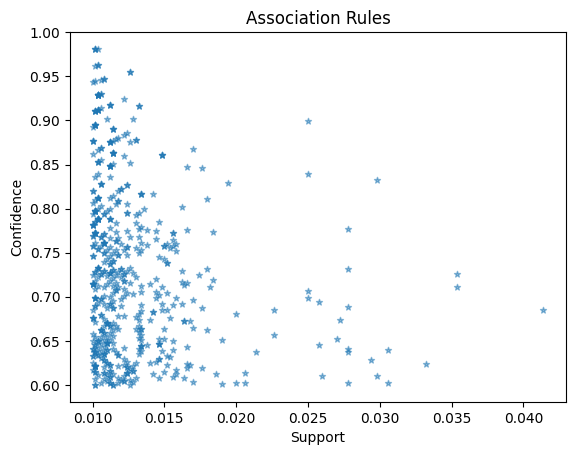

In [25]:
rules.plot.scatter("support", "confidence", alpha=0.5, marker="*")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Association Rules")
plt.show()

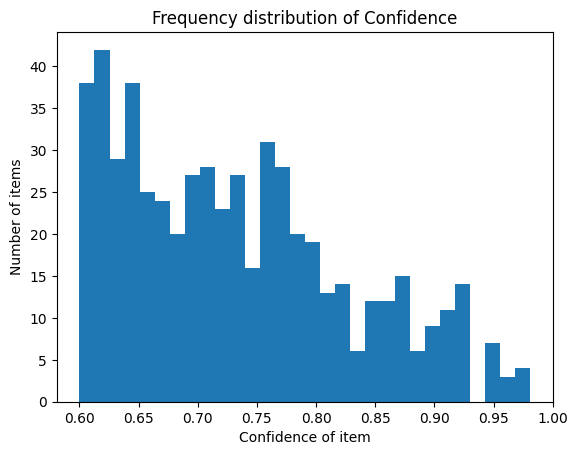

In [26]:
rules.hist("confidence", grid=False, bins=30)
plt.xlabel("Confidence of item")
plt.ylabel("Number of items")
plt.title("Frequency distribution of Confidence")
plt.show()